Pytorch implementation of AAE \
A. Makhzani, J. Shlens, N. Jaitly, I. Goodfellow, B. Frey, Adversarial Autoencoders, ICLR, 2018\
https://ai.google/research/pubs/pub44904

In [32]:
# based on https://github.com/shidilrzf/Adversarial-Autoencoders/blob/master/train.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
EPS = 1e-15

""" GPU """
# Enable CUDA, set tensor type and device
import torch

use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
print(use_cuda)
if use_cuda:
    dtype = torch.cuda.FloatTensor
    device = torch.device('cuda:0')
else:
    dtype = torch.FloatTensor
    device = torch.device('cpu')


True


In [3]:
!mkdir /content/drive/My\ Drive/aae

mkdir: cannot create directory ‘/content/drive/My Drive/aae’: File exists


In [4]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from torch import autograd
import torch.nn as nn
from torch.utils.data import DataLoader, dataset
from torchvision.datasets import MNIST
import torchvision.transforms as T
eps = np.finfo(float).eps

from tqdm.notebook import trange
from torchsummary import summary
import argparse
import os
import time


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
batch_size = 1024
n_classes = 10

In [6]:
train_loader = torch.utils.data.DataLoader(
    MNIST(
        'Data/',
        train=True,
        download=True,
        transform=T.Compose([
                T.transforms.ToTensor(),
                T.Normalize((0.1307,), (0.3081,))  # mean and std deviation of the MNIST dataset
        ])
    ),
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    MNIST(
        'Diles/',
        train=False,
        download=True,
        transform=T.Compose([
                T.transforms.ToTensor(),
                T.Normalize((0.1307,), (0.3081,))
        ])
    ),
    batch_size=batch_size,
    shuffle=False
)

Extracting Data/MNIST/raw/train-images-idx3-ubyte.gz to Data/MNIST/raw


Extracting Data/MNIST/raw/train-labels-idx1-ubyte.gz to Data/MNIST/raw



Extracting Data/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/MNIST/raw


Extracting Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting Diles/MNIST/raw/train-images-idx3-ubyte.gz to Diles/MNIST/raw


Extracting Diles/MNIST/raw/train-labels-idx1-ubyte.gz to Diles/MNIST/raw


Extracting Diles/MNIST/raw/t10k-images-idx3-ubyte.gz to Diles/MNIST/raw


Extracting Diles/MNIST/raw/t10k-labels-idx1-ubyte.gz to Diles/MNIST/raw
Processing...
Done!


In [275]:
supervised = True
dims = 10  if not supervised else 2  # size of representation layer
Model_dir = '/content/drive/My Drive/aae/'
Fig_dir = '/content/drive/My Drive/aae/'

In [276]:
from torch import nn
import torch.nn.functional as F


class Encoder(nn.Module):
    '''Q-net'''
    def __init__(self, dim_input, hidden_dim, dim_z):
        super(Encoder, self).__init__()
        self.dim_input = dim_input  # image size
        self.hidden_dim = hidden_dim
        self.dim_z = dim_z
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_input, self.hidden_dim),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.dim_z),
        ])
        self.network = nn.Sequential(*self.network)
    def forward(self, x):
        z = self.network(x)
        return z

class Decoder(nn.Module):
    '''P-net'''
    def __init__(self, dim_input , hidden_dim, dim_z, supervised=False):
        super(Decoder, self).__init__()
        self.dim_input = dim_input
        self.hidden_dim = hidden_dim
        self.dim_z = dim_z
        self.supervised = supervised
        self.network = []
        input_dim = self.dim_z if not self.supervised else self.dim_z + n_classes
        self.network.extend([
            nn.Linear(input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(self.hidden_dim, self.dim_input),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)
    def forward(self, z):
        x_recon = self.network(z)
        return x_recon

class Discriminator(nn.Module):
    def __init__(self, dims, dim_h):
        super(Discriminator,self).__init__()
        self.dim_z = dims
        self.dim_h = dim_h
        self.network = []
        self.network.extend([
            nn.Linear(self.dim_z, self.dim_h),
            nn.ReLU(),
            nn.Dropout(p=0.2),                         
            nn.Linear(self.dim_h, self.dim_h),
            nn.ReLU(),
            nn.Dropout(p=0.2),                         
            nn.Linear(self.dim_h, 1),
            nn.Sigmoid(),
        ])
        self.network = nn.Sequential(*self.network)

    def forward(self, z):
        disc = self.network(z)
        return disc


In [277]:
def one_hot_encoding(labels, n_classes=10):
    cat = np.array(labels.data.tolist())
    cat = np.eye(n_classes)[cat].astype('float32')
    cat = torch.from_numpy(cat)
    return autograd.Variable(cat)


In [278]:
autoencoder_loss = nn.MSELoss()

def train_validate(
        encoder,
        decoder,
        discriminator,
        dataloader,
        optim_encoder,
        optim_decoder,
        optim_D,
        train
    ):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        discriminator.train()
    else:
        encoder.eval()
        decoder.eval()
        discriminator.eval()

    iteration = 0
    for (data, labels) in dataloader:
        # Reconstruction loss:
        for p in discriminator.parameters():
            p.requires_grad = False

        real_data = autograd.Variable(data).to(device).view(-1, 784)
        encoding = encoder(real_data)

        if decoder.supervised:
            label_hot = one_hot_encoding(labels, n_classes=10).to(device)
            restored_image = decoder(torch.cat((label_hot, encoding), 1))
        else:
            restored_image = decoder(encoding)

        # autoencoder_loss or F.binary_cross_entropy
        reconstruction_loss = autoencoder_loss(restored_image, real_data)
        total_rec_loss += reconstruction_loss.item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            reconstruction_loss.backward()
            optim_encoder.step()
            optim_decoder.step()

        # Discriminator loss:
        # i) latent representation
        encoder.eval()
        z_real_gauss = autograd.Variable(
            torch.randn(data.size()[0], dims)
        ).to(device)
        z_fake_gauss = encoder(real_data)
        # ii) feed into discriminator
        D_real_gauss = discriminator(z_real_gauss)
        D_fake_gauss = discriminator(z_fake_gauss)

        D_loss = -torch.mean(  # cross entropy
            torch.log(D_real_gauss + EPS) +
            torch.log(1 - D_fake_gauss + EPS)
        )
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        # Generator (encoder) loss
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data)
        D_fake_gauss = discriminator(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()

        if (iteration % 100) == 0:
            print(
                'reconstruction loss: %.4f, discriminator loss: %.4f, generator loss: %.4f' %
                (reconstruction_loss.item(), D_loss.item(), G_loss.item()))
            
        iteration += 1

    M = len(dataloader.dataset)
    return total_rec_loss / M, total_disc_loss / M, total_gen_loss / M
              

In [279]:
encoder = Encoder(784, 1000, dims).to(device)      
decoder = Decoder(784, 1000, dims, supervised=supervised).to(device)
discriminator = Discriminator(dims, 500).to(device)

In [280]:
lr = 0.00025

In [281]:
#encode/decode optimizers
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=lr)
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=lr)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=lr * 0.1)

In [282]:
n_epochs = 100

In [283]:
#encoder.load_state_dict(torch.load(Model_dir + 'encoder_z' + str(dims)+'_epch' + str(100) + '.pt'))
#decoder.load_state_dict(torch.load(Model_dir +'decoder_z' + str(dims)+'_epch' + str(100) + '.pt'))
#discriminator.load_state_dict(torch.load(Model_dir +'disc_z' + str(dims)+'_epch'+str(100) + '.pt'))

In [284]:
train_loss = []
val_loss = []
for epoch in trange(n_epochs):
    l1, l2, l3 = train_validate(
        encoder, decoder, discriminator,
        train_loader, optim_encoder, optim_decoder,
        optim_D, train=True
    )
    print('epoch: {} ---- training loss: {:.8f}'.format(epoch, l1))
    train_loss.append(l1)

    if (epoch % 5) == 0:
        l1, l2, l3 = train_validate(
            encoder, decoder, discriminator,
            val_loader, optim_encoder,
            optim_decoder, optim_D, False
        )
        print('epoch: {} ---- validation loss: {:.8f}'.format(epoch, l1))
        val_loss.append(l1)


reconstruction loss: 1.2567, discriminator loss: 1.4004, generator loss: 0.7610
epoch: 0 ---- training loss: 0.00084947
reconstruction loss: 0.7448, discriminator loss: 1.0729, generator loss: 1.3378
epoch: 0 ---- validation loss: 0.00077451
reconstruction loss: 0.7877, discriminator loss: 1.0814, generator loss: 1.4391
epoch: 1 ---- training loss: 0.00074236
reconstruction loss: 0.7339, discriminator loss: 1.1838, generator loss: 1.1680
epoch: 2 ---- training loss: 0.00070829
reconstruction loss: 0.6965, discriminator loss: 1.2426, generator loss: 1.0365
epoch: 3 ---- training loss: 0.00067801
reconstruction loss: 0.6790, discriminator loss: 1.2719, generator loss: 0.9977
epoch: 4 ---- training loss: 0.00065683
reconstruction loss: 0.6615, discriminator loss: 1.2960, generator loss: 0.9432
epoch: 5 ---- training loss: 0.00064449
reconstruction loss: 0.6218, discriminator loss: 1.3282, generator loss: 0.8504
epoch: 5 ---- validation loss: 0.00064946
reconstruction loss: 0.6587, discrim

it's interesting to see how generator loss and discriminator loss drive each other.

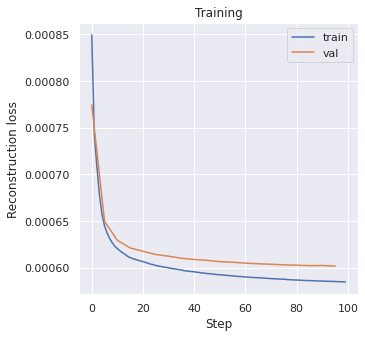

In [285]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 5, 5), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('Reconstruction loss')
plt.legend()
plt.grid(True)
plt.savefig(Fig_dir + 'training_' + str(n_epochs) + 'epochs.png')

In [286]:
#torch.save(encoder.state_dict(), Model_dir + 'encoder_z' + str(dims)+'_epch' + str(n_epochs) + '.pt')
#torch.save(decoder.state_dict(), Model_dir +'decoder_z' + str(dims)+'_epch' + str(n_epochs) + '.pt')
#torch.save(discriminator.state_dict(), Model_dir +'disc_z' + str(dims)+'_epch'+str(n_epochs) + '.pt')

In [22]:
from sklearn.manifold import TSNE


def plot_vis(X_enc, y, dims=2):
    '''Performing t-SNE dimensionality reduction
    and plot in 2 or 3 dimensions.
    '''
    X_tsne = TSNE(n_components=dims).fit_transform(X_enc)
    cmap = plt.get_cmap('rainbow', 10)

    if dims == 2:
      plt.scatter(
          X_tsne[:, 0], X_tsne[:, 1], 
          c=y, edgecolor='black', cmap=cmap
      )
    else:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        p = ax.scatter3D(
            X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], 
            c=y, cmap=cmap, edgecolor='black'
        )
        fig.colorbar(p, drawedges=True)



In [287]:
# visualization of the unsupervised case
# Does our encoder distinguish the classes?
import math
n_points = 1000

X = []
y = []
for (data, labels) in val_loader:
  images = autograd.Variable(data).to(device).view(-1, 784)
  X.append(encoder(images).cpu().data.numpy())
  y.append(labels.cpu().data.numpy())
  if len(X) * images.shape[0] > n_points:
      break

X = np.concatenate(X, 0)
y = np.concatenate(y, 0)
X = X[:n_points, :]
y = y[:n_points]

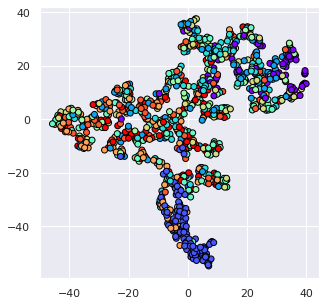

In [288]:
plot_vis(X, y, dims=2)

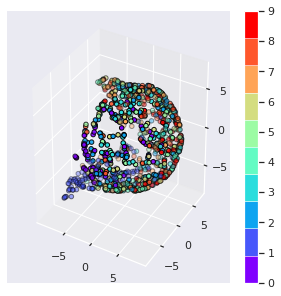

In [289]:
plot_vis(X, y, dims=3)

In [296]:
# visualization of the supervised case
# Does our decoder produce the classes and different styles?

styles = styles + torch.randn(10, dims).reshape(1, -1).repeat(10, 1).reshape(100, dims)
numbers = torch.Tensor(np.eye(10)).repeat(10, 1)
coded = torch.cat([numbers, styles], 1).to(device)
decoded = decoder(coded).cpu().data.numpy()

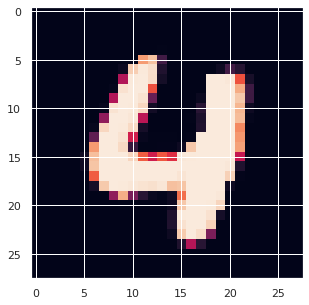

In [297]:
plt.imshow(decoded.reshape(10, 10, 28, 28)[0, 4])

In [312]:
styles = torch.Tensor(
    np.concatenate([
        np.concatenate([np.linspace(-3., 3., 5).reshape(5, 1), np.zeros(shape=(5, 1))], axis=1),
        np.concatenate([np.zeros(shape=(5, 1)), np.linspace(-3., 3., 5).reshape(5, 1)], axis=1),
    ], axis=0)
)

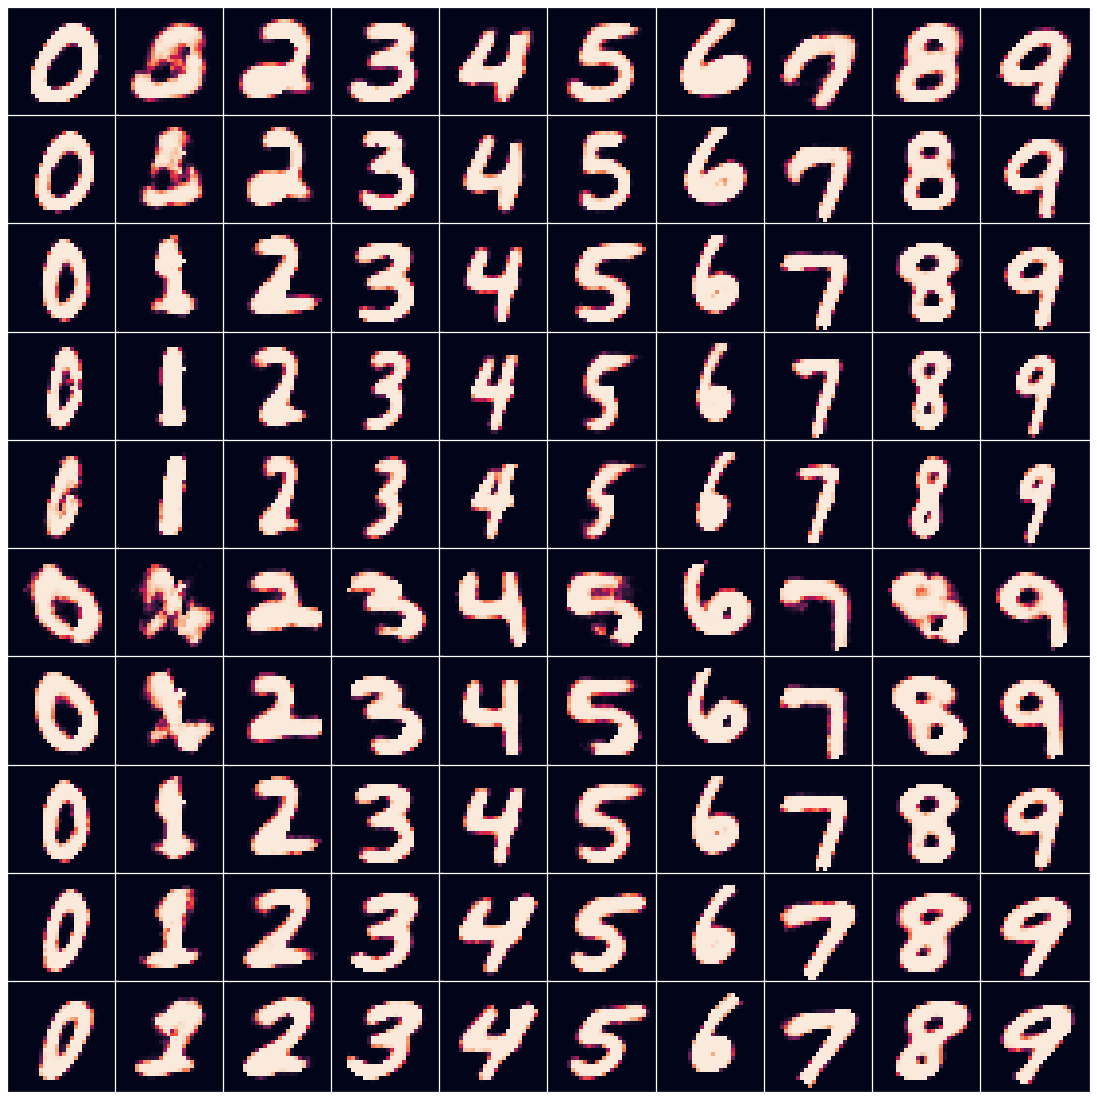

In [320]:
import random

nrows = styles.shape[0]
ncols = 10
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15 * nrows / 10))
numbers = torch.Tensor(np.eye(10))
for row, style in enumerate(styles):
    for col, number in enumerate(numbers):
        coded = torch.cat([number, style], -1).to(device)
        decoded = decoder(coded).cpu().data.numpy()
        ax = axes[row, col]
        ax.imshow(decoded.reshape(28, 28))
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=-.2)